In [4]:
import datetime
import pandas as pd
import numpy as np
import scipy
import vectorbt as vbt
import matplotlib.pyplot as plt
import seaborn as sns
import alphalens
from scipy import stats
# from finlab import data
# from finlab import backtest
# from finlab import dataframe
from alphalens import performance
from alphalens import plotting
from alphalens import tears
from alphalens import utils
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler

In [5]:
pricefolder = './TEJ_調整後股價資料'
revenuefolder = './TEJ_月營收資料'

In [6]:
def stand(factor):
  """自实现标准化
  """
  mean = factor.mean()
  std = factor.std()
  return (factor - mean)/std

# 數據處理

In [56]:
收盤價 = pd.read_csv(pricefolder + "/收盤價(元).csv")
收盤價['年月日'] = pd.to_datetime(收盤價['年月日'])
收盤價 = 收盤價.set_index('年月日')
收盤價.ffill(inplace = True)

In [8]:
開盤價 = pd.read_csv(pricefolder + "/開盤價(元).csv")
開盤價['年月日'] = pd.to_datetime(開盤價['年月日'])
開盤價 = 開盤價.set_index('年月日')
開盤價.ffill(inplace = True)

In [9]:
本益比 = pd.read_csv(pricefolder + '/本益比-TSE.csv')
本益比['年月日'] = pd.to_datetime(本益比['年月日'])
本益比 = 本益比.set_index('年月日','asset')
本益比.ffill(inplace = True)
本益比.replace(to_replace = '          -', value = np.nan, regex=True, inplace = True)
本益比 = 本益比.astype(float)    

#去極值、標準化

for col in 本益比.columns: 
     本益比[col] = winsorize(本益比[col], limits=0.025)
     本益比[col] = stand(本益比[col])



C:\Kit\Python\Envs\TMBA\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (1,2,7,8,9,10,11,13,16,17,20,22,23,24,32,33,36,38,45,48,49,52,53,54,55,57,59,62,63,64,67,71,74,75,76,77,78,80,81,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,126,128,133,134,137,141,142,143,144,146,148,151,152,153,154,155,159,160,161,162,166,167,169,171,172,183,185,186,187,190,191,192,193,198,200,204,205,208,210,213,216,220,221,222,225,226,227,231,232,233,235,236,237,241,242,243,244,245,246,247,248,249,250,251,252,255,257,260,261,263,264,265,266,269,271,272,273,274,275,276,277,279,280,281,282,283,284,285,286,289,290,292,295,296,297,299,300,301,306,309,310,311,313,315,318,324,325,328,329,330,331,334,336,338,340,341,342,345,348,350,351,356,358,359,364,365,369,371,374,375,377,379,380,381,383,384,385,387,389,390,395,396,401,402,404,405,410,412,413,414,417,418,419,421,422,424,425,426,427,429,436,438,

In [119]:
月營收YoY = pd.read_csv(revenuefolder + "/單月營收成長率％.csv", low_memory = False)
月營收YoY.drop([len(月營收YoY) - 1], inplace = True)
月營收YoY.drop([0], inplace = True)
月營收YoY["年月"] = pd.to_datetime(月營收YoY["年月"], format = '%Y-%m')
月營收YoY.set_index(["年月"], inplace = True)

月營收YoY.replace(to_replace = "-", value = np.nan, regex=True, inplace = True)
月營收YoY = 月營收YoY.astype(float)




#
for col in 月營收YoY.columns:
    月營收YoY[col] = winsorize(月營收YoY[col], limits=0.025)
    月營收YoY[col] = stand(月營收YoY[col])



In [43]:
月營收公布日 = pd.read_csv(revenuefolder + "/營收發布日.csv", low_memory = False)
月營收公布日.drop([len(月營收公布日) - 1], inplace = True)
月營收公布日["年月"] = pd.to_datetime(月營收公布日["年月"], format = '%Y-%m')
月營收公布日.set_index(["年月"], inplace = True)
月營收公布日.replace(to_replace = '        ', value = np.nan, regex=True, inplace = True)

In [12]:
盈餘公布日 = pd.read_csv(revenuefolder + "/營收發布日.csv", low_memory = False)
盈餘公布日.drop([len(盈餘公布日) - 1], inplace = True)
盈餘公布日["年月"] = pd.to_datetime(盈餘公布日["年月"], format = '%Y-%m')
盈餘公布日.set_index(["年月"], inplace = True)
盈餘公布日.replace(to_replace = '        ', value = np.nan, regex=True, inplace = True)

# 單因子的有效性檢驗

## PE因子

In [13]:
本益比 = 本益比.stack(0)
本益比 = 本益比.rename_axis(index=["date", "asset"])
本益比

date        asset
2005-01-03  1101     0.239873
            1102    -1.187814
            1103    -0.276333
            1104    -0.407724
            1107    -0.762421
                       ...   
2021-08-20  9946     0.182913
            9951    -0.523738
            9958    -0.521721
            9960    -0.308795
            9962    -0.198722
Length: 5382428, dtype: float64

In [237]:
factor_return = utils.get_clean_factor_and_forward_returns(本益比, 收盤價,periods=(5, 13, 21),quantiles=10)

Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [238]:
IC = performance.factor_information_coefficient(factor_return)

## PE單因子效果分析圖表

array([<AxesSubplot:title={'center':'5D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <AxesSubplot:title={'center':'13D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <AxesSubplot:title={'center':'21D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

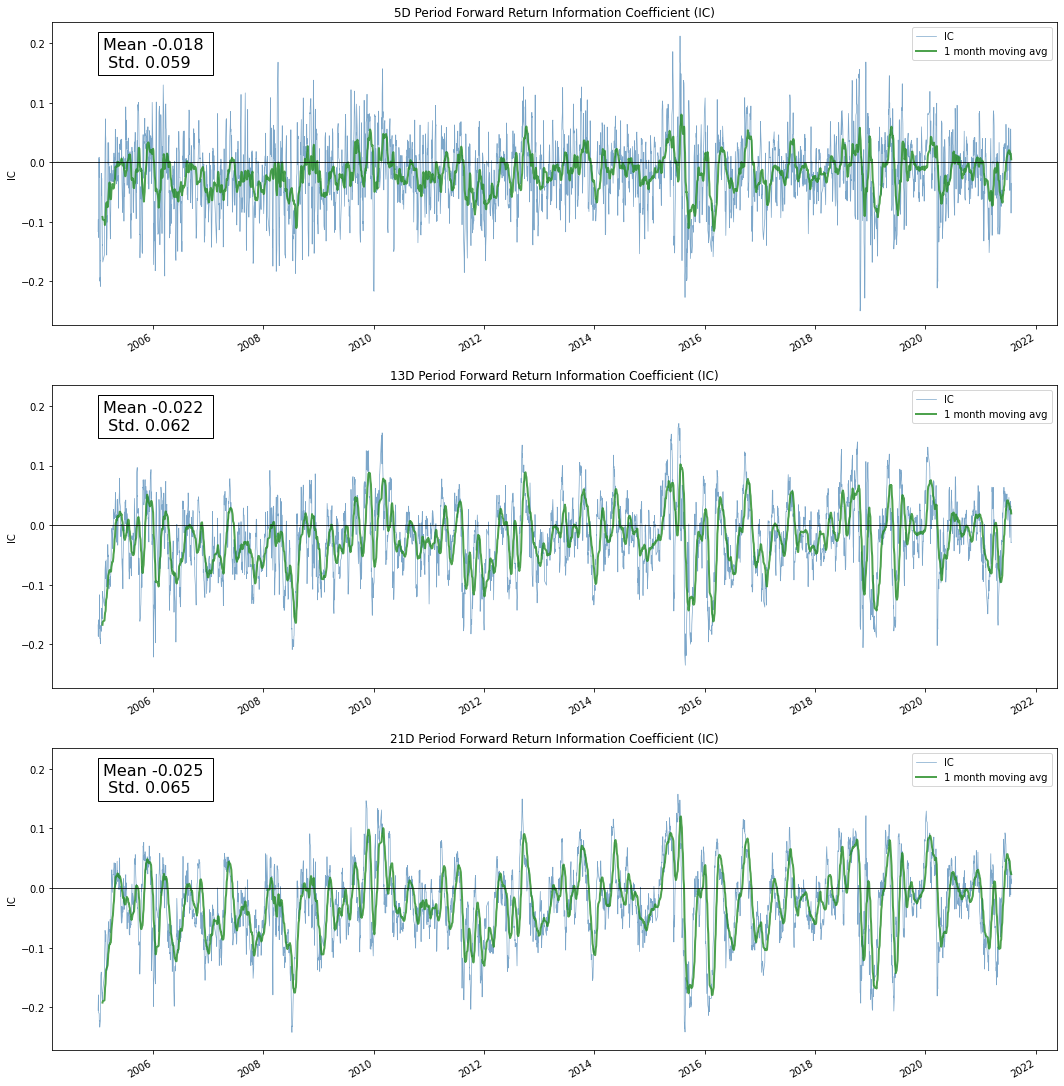

In [239]:
plotting.plot_ic_ts(IC)

array([<AxesSubplot:title={'center':'5D Period IC'}, xlabel='IC'>,
       <AxesSubplot:title={'center':'13D Period IC'}, xlabel='IC'>,
       <AxesSubplot:title={'center':'21D Period IC'}, xlabel='IC'>],
      dtype=object)

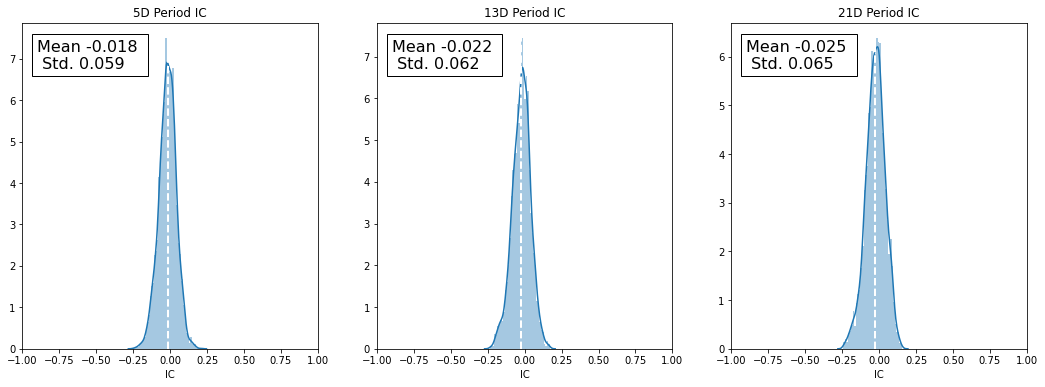

In [240]:
plotting.plot_ic_hist(IC)

array([<AxesSubplot:title={'center':'5D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <AxesSubplot:title={'center':'13D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <AxesSubplot:title={'center':'21D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>],
      dtype=object)

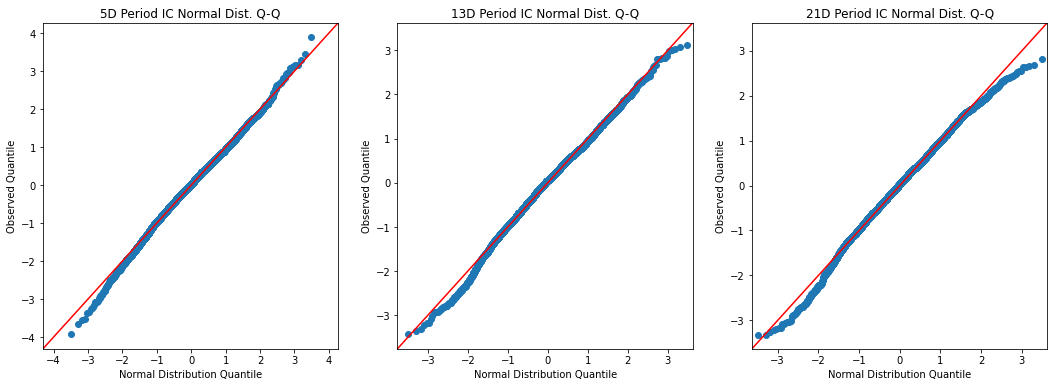

In [241]:
plotting.plot_ic_qq(IC)

array([<AxesSubplot:title={'center':'Monthly Mean 5D Period IC'}>,
       <AxesSubplot:title={'center':'Monthly Mean 13D Period IC'}>,
       <AxesSubplot:title={'center':'Monthly Mean 21D Period IC'}>],
      dtype=object)

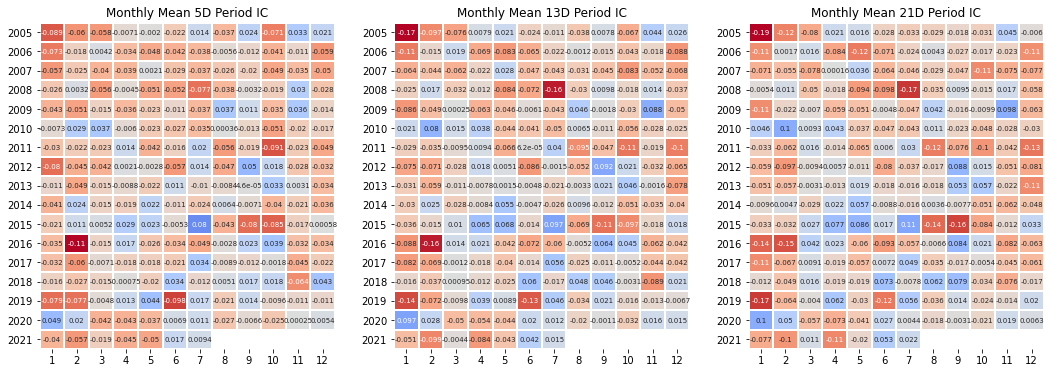

In [242]:
IC_month = performance.mean_information_coefficient(factor_return, group_adjust=False, by_group=False, by_time='1m')
plotting.plot_monthly_ic_heatmap(IC_month)

## PE因子收益率計算

Returns Analysis


,5D,13D,21D
Ann. alpha,-0.053,-0.046,-0.043
beta,0.003,0.008,0.005
Mean Period Wise Return Top Quantile (bps),-15.304,-12.881,-12.592
Mean Period Wise Return Bottom Quantile (bps),12.550,10.837,10.649
Mean Period Wise Spread (bps),-27.854,-23.708,-23.231


<Figure size 432x288 with 0 Axes>

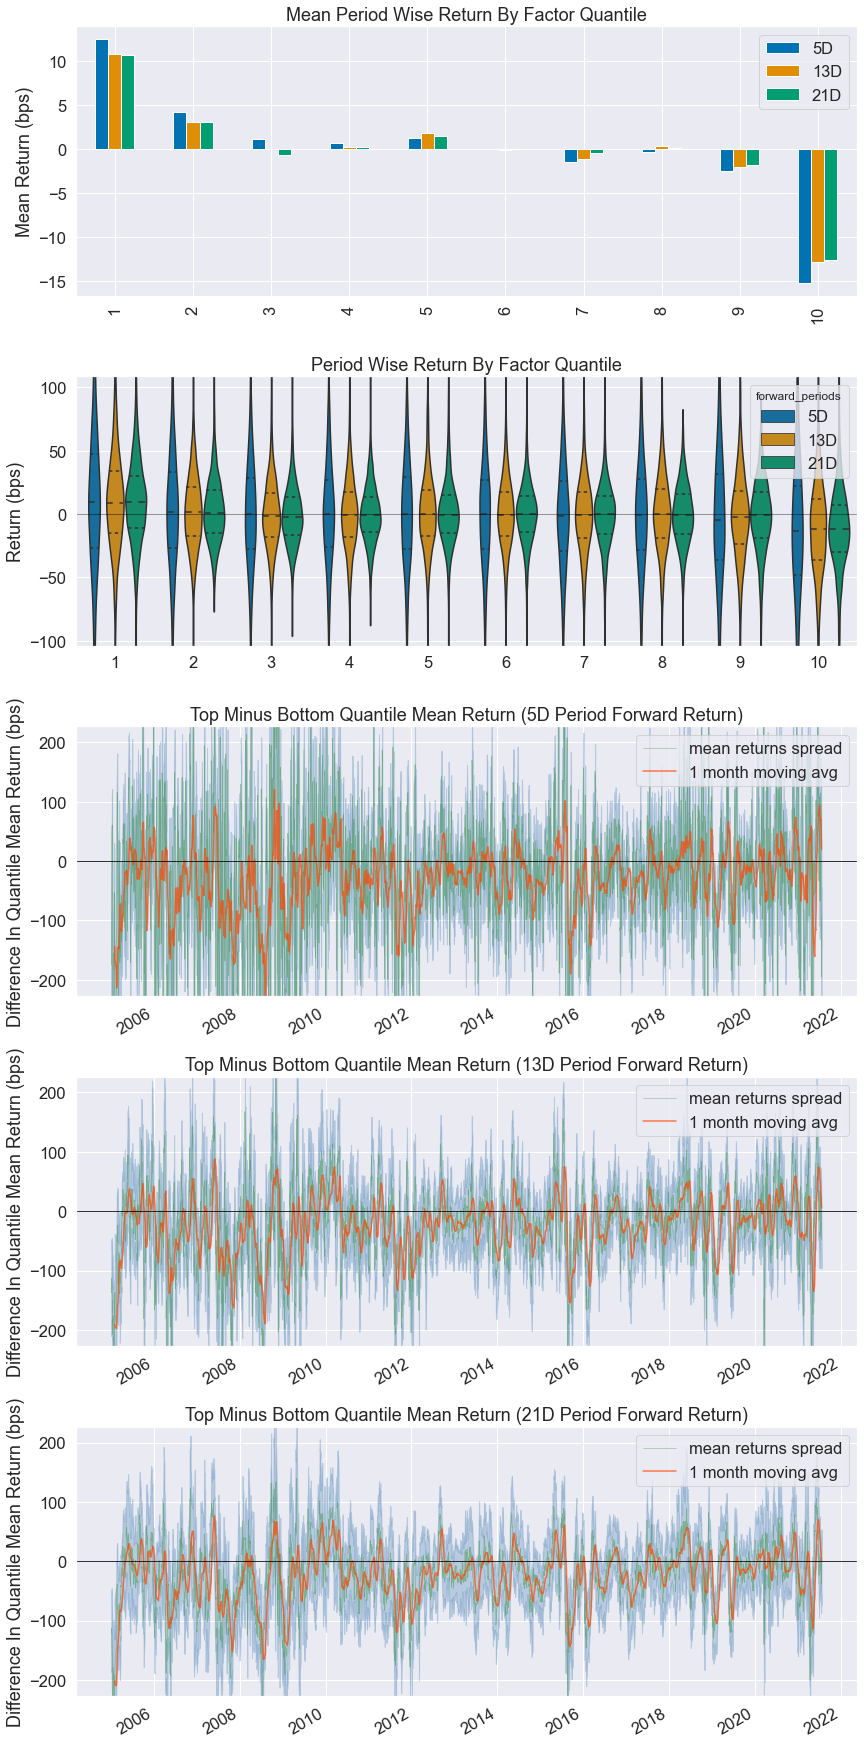

In [243]:
tears.create_returns_tear_sheet(factor_return)

In [245]:
print("5天因子平均收益率: {}".format(performance.factor_returns(factor_return).iloc[:, 0].mean()))
print("13天因子平均收益率: {}".format(performance.factor_returns(factor_return).iloc[:, 1].mean()))
print("21天因子平均收益率: {}".format(performance.factor_returns(factor_return).iloc[:, 2].mean()))

1天因子平均收益率: -0.0010819628864791257
13天因子平均收益率: -0.0023574031812076015
21天因子平均收益率: -0.003597309185155778
5天因子平均收益率: -0.0010819628864791257
13天因子平均收益率: -0.0023574031812076015
21天因子平均收益率: -0.003597309185155778


## 月營收YOY

In [195]:
月營收YoY = 月營收YoY.stack(0)
月營收YoY = 月營收YoY.rename_axis(index=["date", "asset"])

In [204]:
收盤價.resample('1D').mean().index

DatetimeIndex(['2005-01-03', '2005-01-04', '2005-01-05', '2005-01-06',
               '2005-01-07', '2005-01-08', '2005-01-09', '2005-01-10',
               '2005-01-11', '2005-01-12',
               ...
               '2021-08-11', '2021-08-12', '2021-08-13', '2021-08-14',
               '2021-08-15', '2021-08-16', '2021-08-17', '2021-08-18',
               '2021-08-19', '2021-08-20'],
              dtype='datetime64[ns]', name='date', length=6074, freq='D')

In [217]:
factor_return = utils.get_clean_factor_and_forward_returns(月營收YoY.unstack().resample('D').first().stack(), 收盤價.resample('1D').mean(),periods=(5, 13, 21),quantiles=6,max_loss=0.3)

Dropped 20.7% entries from factor data: 20.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 30.0%, not exceeded: OK!


In [218]:
IC = performance.factor_information_coefficient(factor_return)

C:\Kit\Python\Envs\TMBA\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


array([<AxesSubplot:title={'center':'5D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <AxesSubplot:title={'center':'13D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <AxesSubplot:title={'center':'21D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

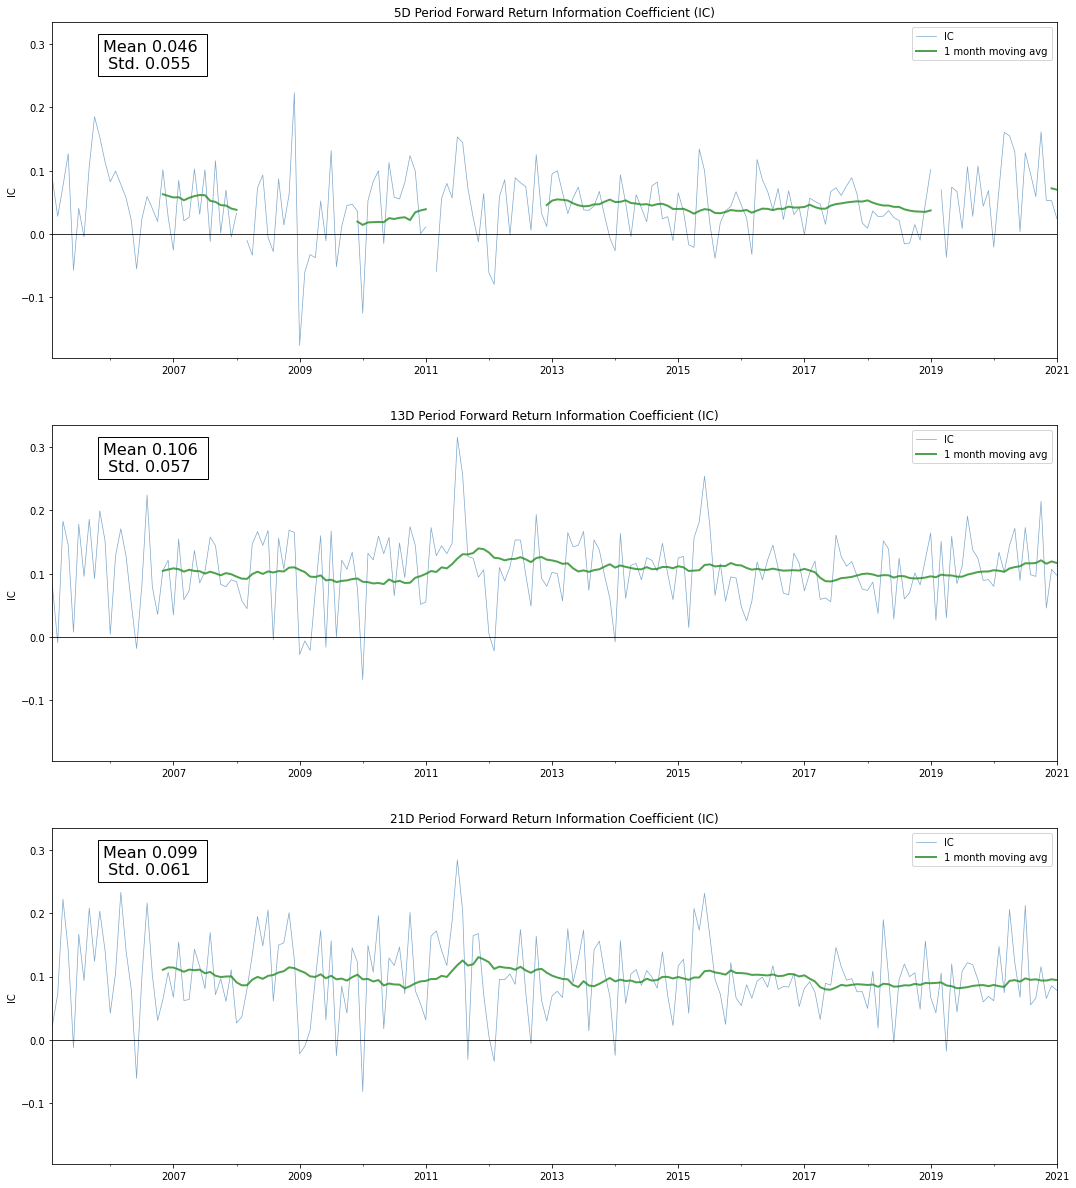

In [219]:
plotting.plot_ic_ts(IC)

array([<AxesSubplot:title={'center':'5D Period IC'}, xlabel='IC'>,
       <AxesSubplot:title={'center':'13D Period IC'}, xlabel='IC'>,
       <AxesSubplot:title={'center':'21D Period IC'}, xlabel='IC'>],
      dtype=object)

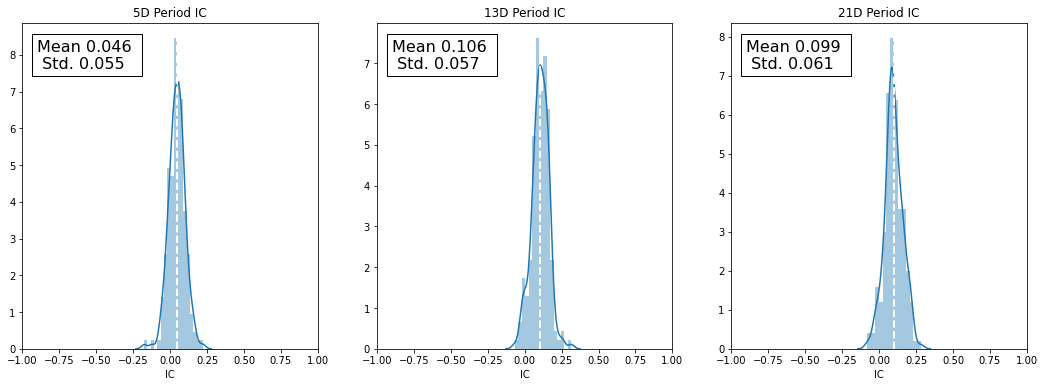

In [222]:
plotting.plot_ic_hist(IC)

array([<AxesSubplot:title={'center':'5D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <AxesSubplot:title={'center':'13D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <AxesSubplot:title={'center':'21D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>],
      dtype=object)

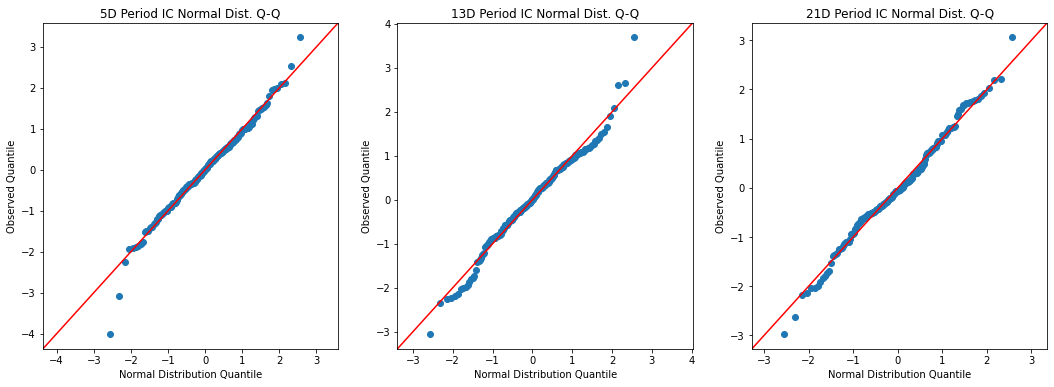

In [223]:
plotting.plot_ic_qq(IC)

C:\Kit\Python\Envs\TMBA\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


array([<AxesSubplot:title={'center':'Monthly Mean 5D Period IC'}>,
       <AxesSubplot:title={'center':'Monthly Mean 13D Period IC'}>,
       <AxesSubplot:title={'center':'Monthly Mean 21D Period IC'}>],
      dtype=object)

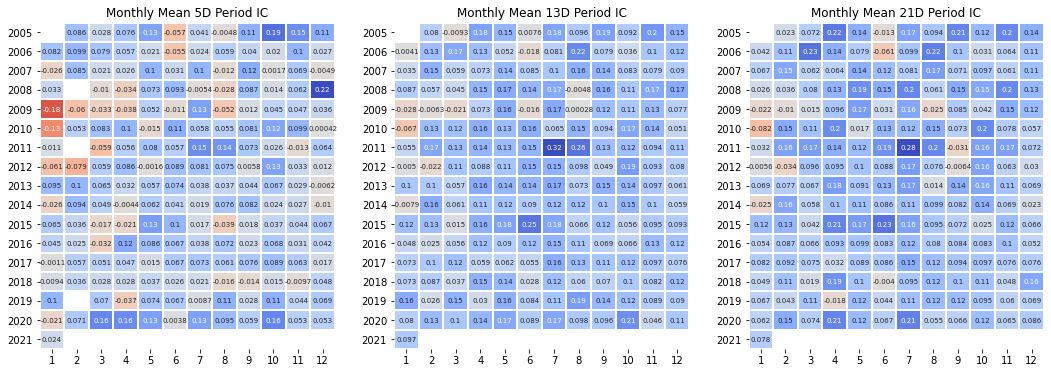

In [224]:
IC_month = performance.mean_information_coefficient(factor_return, group_adjust=False, by_group=False, by_time='1m')
plotting.plot_monthly_ic_heatmap(IC_month)

Returns Analysis


,5D,13D,21D
Ann. alpha,0.134,0.192,0.146
beta,-0.011,-0.008,0.006
Mean Period Wise Return Top Quantile (bps),31.550,43.316,33.817
Mean Period Wise Return Bottom Quantile (bps),-23.967,-35.629,-27.866
Mean Period Wise Spread (bps),55.517,78.928,61.645


<Figure size 432x288 with 0 Axes>

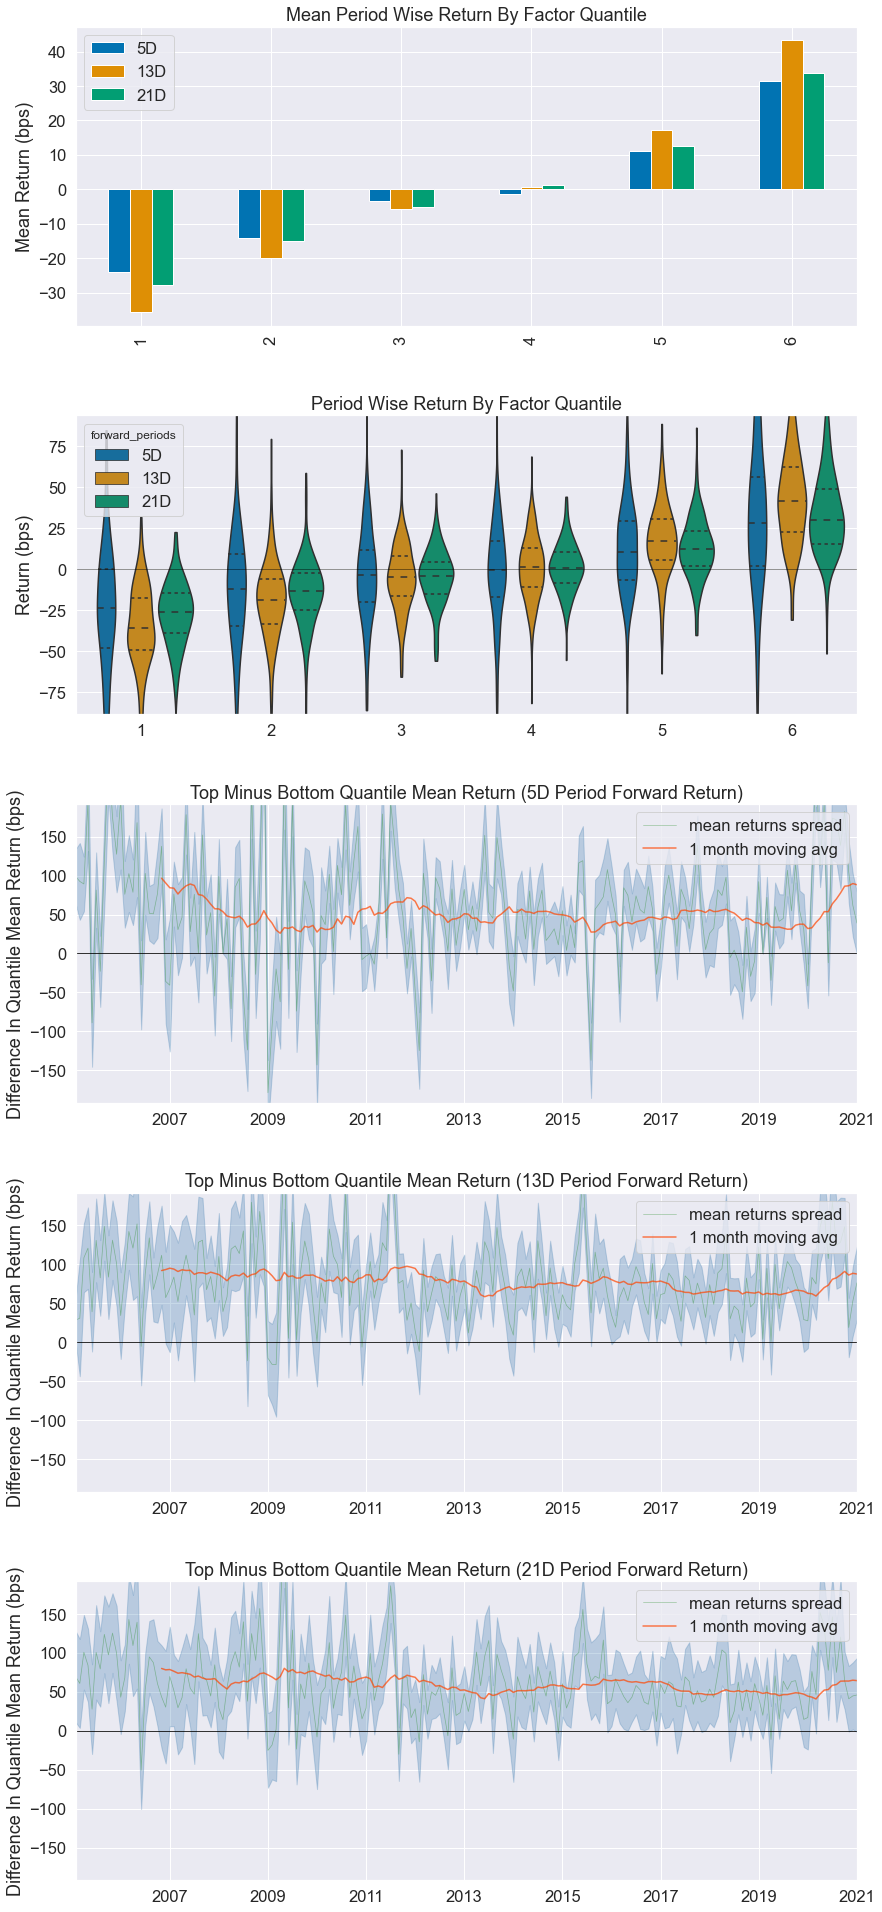

In [225]:
tears.create_returns_tear_sheet(factor_return)

In [226]:
print("5天因子平均收益率: {}".format(performance.factor_returns(factor_return).iloc[:, 0].mean()))
print("13天因子平均收益率: {}".format(performance.factor_returns(factor_return).iloc[:, 1].mean()))
print("21天因子平均收益率: {}".format(performance.factor_returns(factor_return).iloc[:, 2].mean()))

5天因子平均收益率: 0.002460746386766638
13天因子平均收益率: 0.00905102865917048
21天因子平均收益率: 0.011429757510528235


# 雙因子

In [227]:
月營收_return = utils.get_clean_factor_and_forward_returns(月營收YoY.unstack().resample('D').first().stack(), 收盤價.resample('1D').mean(),periods=(5, 13, 21),quantiles=6,max_loss=0.3)
本益比_return = utils.get_clean_factor_and_forward_returns(本益比, 收盤價,periods=(5, 13, 21),quantiles=6,max_loss=0.3)

Dropped 20.7% entries from factor data: 20.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 30.0%, not exceeded: OK!
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 30.0%, not exceeded: OK!


In [246]:
s1 = pd.merge(本益比_return, 月營收_return, how='inner', on=['date', 'asset'])

In [229]:
s1

5D_x     13D_x     21D_x  factor_x  factor_quantile_x  \
date       asset                                                              
2005-02-01 1101   0.009942  0.017407  0.044772 -0.009895                  6   
           1102   0.018769  0.044597  0.039909 -1.256547                  1   
           1103   0.007143  0.035716 -0.010721 -0.296509                  4   
           1104  -0.015930  0.007976  0.015930 -0.451814                  3   
           1108   0.005560  0.005560 -0.015548 -0.485433                  3   
...                    ...       ...       ...       ...                ...   
2020-12-01 9940  -0.026623 -0.024959 -0.033279  0.247255                  4   
           9941  -0.014851 -0.014851 -0.004950  0.530893                  5   
           9942  -0.014664 -0.005867  0.008797  0.897007                  5   
           9943  -0.001582  0.009494  0.000000  0.042714                  4   
           9944  -0.027150 -0.004526  0.011312  0.063695                  4   

                      5D_y     13D_y     21D_y  factor_y  factor_quantile_y  
date       asset                                                             
2005-02-01 1101   0.034830  0.039801  0.000000 -1.721108                  1  
           1102   0.009376  0.028163 -0.004705 -0.816602                  3  
           1103   0.003566 -0.014286  0.010709 -0.466141                  4  
           1104  -0.015930 -0.015930 -0.019929 -1.847620                  1  
           1108  -0.005543  0.000000  0.005560 -1.941576                  1  
...                    ...       ...       ...       ...                ...  
2020-12-01 9940  -0.003328 -0.034943 -0.046589 -0.011624                  4  
           9941  -0.009901 -0.009901 -0.020792 -0.383045                  2  
           9942   0.002932 -0.008798 -0.001467  0.135986                  4  
           9943   0.003165  0.000000 -0.003165 -0.427455                  2  
           9944   0.004526 -0.011312  0.047510 -0.567870                  2  

[108614 rows x 10 columns]

In [235]:
rho, pval = stats.spearmanr(s1[['5D_x','13D_x', '21D_x',]],
                            s1[['5D_y','13D_y', '21D_y',]])

In [236]:
rho

array([[1.        , 0.63179888, 0.54284843, 0.76345321, 0.72737541,
        0.63123066],
       [0.63179888, 1.        , 0.81607297, 0.49077957, 0.80552824,
        0.94132521],
       [0.54284843, 0.81607297, 1.        , 0.41167641, 0.67746158,
        0.84913065],
       [0.76345321, 0.49077957, 0.41167641, 1.        , 0.58969792,
        0.49829964],
       [0.72737541, 0.80552824, 0.67746158, 0.58969792, 1.        ,
        0.79067243],
       [0.63123066, 0.94132521, 0.84913065, 0.49829964, 0.79067243,
        1.        ]])

In [233]:
pval

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        9.61627033e-008, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 3.96337853e-111],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        6.15594497e-027, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.29005523e-196],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.15070224e-034, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 7.71002113e-241],
       [9.61627033e-008, 6.15594497e-027, 1.15070224e-034,
        0.00000000e+000, 3.84552073e-001, 5.72420248e-022,
        3.98263984e-027, 1.01585859e-306],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        3.84552073e-001, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 5.22030873e-079],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        5.72420248e-022, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 5.27126861e-254],
       [0.00000000e+000, 0.0000000

## 到期日計算